# **House Prices - Advanced Regression Techniques** 

(https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/) - *projekt na Uczenie Maszynowe*

*by Bartosz Rogowski & Aleksandra Rolka*


In [203]:
# to uncomment when running from Google collab

# from google.colab import drive
# drive.mount('/content/drive')

# !unzip drive/Shareddrives/ML-team/house-prices-advanced-regression-techniques.zip -d data
# data_folder_path = '/content/data'

In [204]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import isnan

In [205]:
data_folder_path ='./data/' # to remove after uploading on Google collab
train_data = pd.read_csv(data_folder_path+"/train.csv")
test_data_X = pd.read_csv(data_folder_path+"/test.csv")
test_data_Y = pd.read_csv(data_folder_path+"/sample_submission.csv")

In [206]:
def encode_not_numeric_collumns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

In [207]:
train_data = encode_not_numeric_collumns(train_data)
test_data_X = encode_not_numeric_collumns(test_data_X)

In [208]:
def convert_Nan_values(df, target_value=0):
  for column_name in df:
    df[column_name] = df[column_name].fillna(target_value)
  return df

In [209]:
train_data = convert_Nan_values(train_data)
test_data_X = convert_Nan_values(test_data_X)
test_data_Y = convert_Nan_values(test_data_Y)

In [210]:
# train_data.corr()

[('PoolArea', 'PoolQC', 0.9384016221034005),
 ('GarageCars', 'GarageArea', 0.882475414281462),
 ('GarageQual', 'GarageCond', 0.838395909015938),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8254893743088425),
 ('TotalBsmtSF', '1stFlrSF', 0.8195299750050339),
 ('GarageYrBlt', 'GarageQual', -0.8698543661864783)]

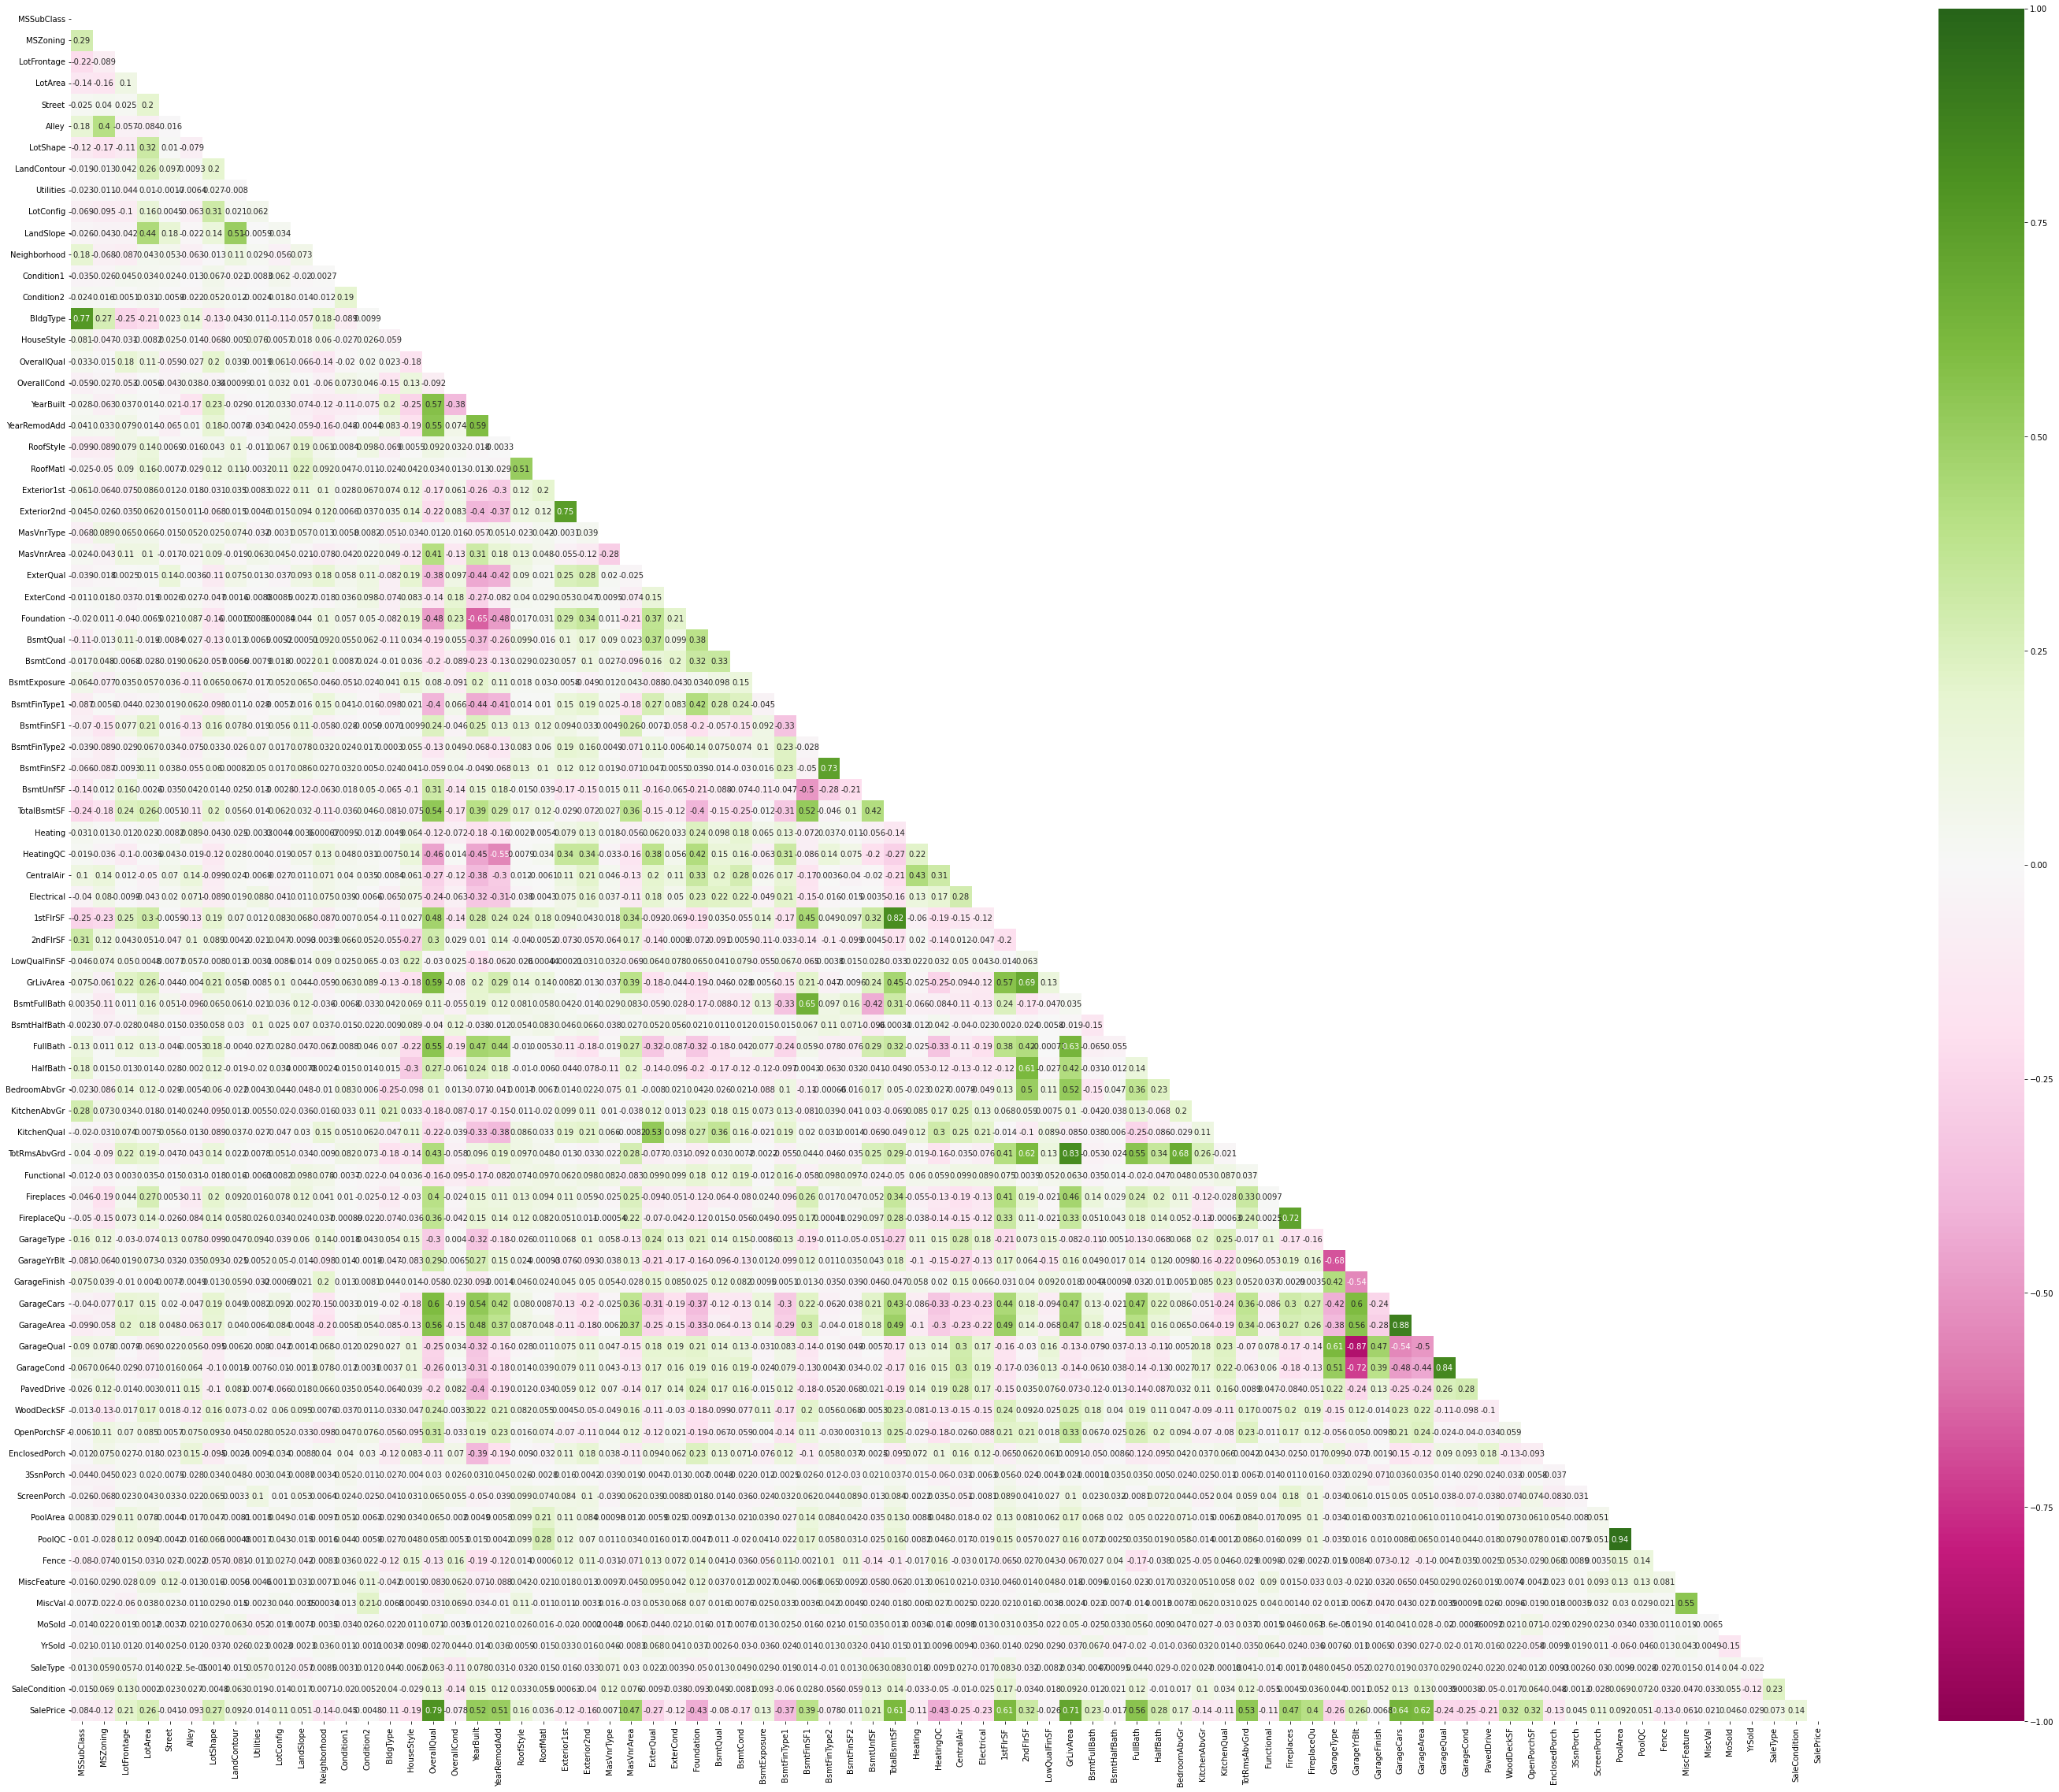

In [211]:
corr = train_data.drop(['Id'], axis=1).corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca())
high_corr = []
for column in train_data.drop(['Id'], axis=1):
   for col in train_data.drop(['Id'], axis=1):
     if abs(lower_tri[column][col]) > 0.8:
       high_corr.append((column, col, lower_tri[column][col]))
sorted(high_corr, key=lambda x: x[2], reverse=True)

In [212]:
train_data_X = train_data.drop(['SalePrice'], axis=1)
train_data_Y = train_data.loc[:,["SalePrice"]].to_numpy()
test_data_Y = test_data_Y.drop(['Id'], axis=1).to_numpy()

In [213]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(train_data_X,train_data_Y, )  
predicted = model.predict(test_data_X)

In [214]:
model.score(test_data_X, test_data_Y)

-22.510845496553166

In [215]:
for i in range(15):
    relative_error = (test_data_Y[i][0] - predicted[i][0])/test_data_Y[i][0]
    print(f"Actual: {test_data_Y[i][0]:.2f}\tPrediction: {predicted[i][0]:.2f}\t\tDifference: {(100*relative_error):.2f}%")

print("Root mean squarred error is : ", np.sqrt(mean_squared_error(test_data_Y, predicted)), "\n\n")

Actual: 169277.05	Prediction: 109772.99		Difference: 35.15%
Actual: 187758.39	Prediction: 174281.06		Difference: 7.18%
Actual: 183583.68	Prediction: 170692.53		Difference: 7.02%
Actual: 179317.48	Prediction: 198710.95		Difference: -10.82%
Actual: 150730.08	Prediction: 195870.16		Difference: -29.95%
Actual: 177150.99	Prediction: 173032.63		Difference: 2.32%
Actual: 172070.66	Prediction: 181948.37		Difference: -5.74%
Actual: 175110.96	Prediction: 164036.04		Difference: 6.32%
Actual: 162011.70	Prediction: 199214.08		Difference: -22.96%
Actual: 160726.25	Prediction: 100227.39		Difference: 37.64%
Actual: 157933.28	Prediction: 209683.34		Difference: -32.77%
Actual: 145291.25	Prediction: 107577.22		Difference: 25.96%
Actual: 159672.02	Prediction: 87124.60		Difference: 45.44%
Actual: 164167.52	Prediction: 151426.29		Difference: 7.76%
Actual: 150891.64	Prediction: 98117.15		Difference: 34.98%
Root mean squarred error is :  80066.46774618363 




In [216]:
import xgboost as xgb

model = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42)
model.fit(train_data_X, train_data_Y)
predicted = model.predict(test_data_X)

In [217]:
for i in range(15):
    relative_error = (test_data_Y[i][0] - predicted[i])/test_data_Y[i][0]
    print(f"Actual: {test_data_Y[i][0]:.2f}\tPrediction: {predicted[i]:.2f}\t\tDifference: {(100*relative_error):.2f}%")

print("Root mean squarred error is : ", np.sqrt(mean_squared_error(test_data_Y, predicted)), "\n\n")

Actual: 169277.05	Prediction: 142040.92		Difference: 16.09%
Actual: 187758.39	Prediction: 162533.53		Difference: 13.43%
Actual: 183583.68	Prediction: 182915.89		Difference: 0.36%
Actual: 179317.48	Prediction: 193554.05		Difference: -7.94%
Actual: 150730.08	Prediction: 159921.36		Difference: -6.10%
Actual: 177150.99	Prediction: 167146.66		Difference: 5.65%
Actual: 172070.66	Prediction: 197505.22		Difference: -14.78%
Actual: 175110.96	Prediction: 161172.25		Difference: 7.96%
Actual: 162011.70	Prediction: 164168.50		Difference: -1.33%
Actual: 160726.25	Prediction: 125362.09		Difference: 22.00%
Actual: 157933.28	Prediction: 174550.58		Difference: -10.52%
Actual: 145291.25	Prediction: 99084.10		Difference: 31.80%
Actual: 159672.02	Prediction: 98898.06		Difference: 38.06%
Actual: 164167.52	Prediction: 154929.36		Difference: 5.63%
Actual: 150891.64	Prediction: 115195.30		Difference: 23.66%
Root mean squarred error is :  65519.16559271148 




In [218]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.005, max_iter=50000)
model.fit(train_data_X, train_data_Y)
predicted = model.predict(test_data_X)


In [219]:
for i in range(15):
    relative_error = (test_data_Y[i][0] - predicted[i])/test_data_Y[i][0]
    print(f"Actual: {test_data_Y[i][0]:.2f}\tPrediction: {predicted[i]:.2f}\t\tDifference: {(100*relative_error):.2f}%")

print("Root mean squarred error is : ", np.sqrt(mean_squared_error(test_data_Y, predicted)), "\n\n")

Actual: 169277.05	Prediction: 109773.00		Difference: 35.15%
Actual: 187758.39	Prediction: 174280.66		Difference: 7.18%
Actual: 183583.68	Prediction: 170692.55		Difference: 7.02%
Actual: 179317.48	Prediction: 198710.99		Difference: -10.82%
Actual: 150730.08	Prediction: 195870.16		Difference: -29.95%
Actual: 177150.99	Prediction: 173032.65		Difference: 2.32%
Actual: 172070.66	Prediction: 181948.50		Difference: -5.74%
Actual: 175110.96	Prediction: 164036.04		Difference: 6.32%
Actual: 162011.70	Prediction: 199214.17		Difference: -22.96%
Actual: 160726.25	Prediction: 100227.42		Difference: 37.64%
Actual: 157933.28	Prediction: 209683.37		Difference: -32.77%
Actual: 145291.25	Prediction: 107577.07		Difference: 25.96%
Actual: 159672.02	Prediction: 87124.46		Difference: 45.44%
Actual: 164167.52	Prediction: 151426.26		Difference: 7.76%
Actual: 150891.64	Prediction: 98117.26		Difference: 34.98%
Root mean squarred error is :  80066.3809404609 


